# 02 - Model Fitting

Bayesian Marketing Mix Model fitting using PyMC-Marketing.

- ~52 weekly observations (Jul 2015 - Jun 2016)
- 4 channel groups (aggregated from 7 raw channels to reduce multicollinearity)
- Weekly data aggregated from daily transactions; monthly media spend pro-rata distributed

## Channel Grouping Rationale

Raw channel spend correlations revealed severe multicollinearity:
- Online.marketing ↔ Affiliates: r = 0.99
- Digital ↔ SEM: r = 0.98
- Content.Marketing ↔ SEM: r = 0.96
- Digital ↔ Content.Marketing: r = 0.91

With 7 channels × 3 parameters = 21 channel params and only 12 distinct monthly
media patterns, the model was unidentifiable (R-hat=4.26, ESS=4, 17 divergences).

**Solution:** Group correlated channels into 4 groups:

| Group | Raw Channels | Annual Spend Share |
|-------|-------------|-------------------|
| TV | TV | 5.6% |
| Sponsorship | Sponsorship | 46.6% |
| Digital | Digital + SEM + Content.Marketing | 16.3% |
| Online | Online.marketing + Affiliates | 31.5% |

This reduces channel params from 21 → 12, total model params from ~26 → ~17.

## Workflow
1. Configure model
2. Load & preprocess weekly data (with channel grouping)
3. Initialize model
4. Prior predictive check
5. Fit (MCMC sampling)
6. Convergence diagnostics
7. Posterior predictive check
8. Channel decomposition & contribution analysis

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
%matplotlib inline

from mmm_test.config import OUTPUTS_DIR, ModelConfig
from mmm_test.data import CHANNEL_GROUPS, load_mmm_weekly_data
from mmm_test.diagnostics import check_convergence
from mmm_test.model import (
    build_model,
    fit_model,
    sample_posterior_predictive,
    sample_prior_predictive,
)
from mmm_test.plotting import plot_channel_contributions, plot_trace

---
## Step 1: Configure Model

In [2]:
config = ModelConfig()

print(f"Date column: {config.date_column}")
print(f"Target: {config.target_column}")
print(f"Channels ({len(config.channel_columns)}): {config.channel_columns}")
print(f"Controls: {config.control_columns}")
print(f"Adstock max lag: {config.adstock_max_lag}")
print(f"Target accept: {config.target_accept}")
print(f"Chains: {config.chains}, Draws: {config.draws}, Tune: {config.tune}")
print("\nPriors (model_config):")
for k, v in config.get_model_config().items():
    print(f"  {k}: {v}")

Date column: Date
Target: total_gmv
Channels (4): ['TV', 'Sponsorship', 'Digital', 'Online']
Controls: ['NPS', 'total_Discount', 'sale_days']
Adstock max lag: 4
Target accept: 0.95
Chains: 4, Draws: 1000, Tune: 2000

Priors (model_config):
  intercept: Prior("Normal", mu=0, sigma=2)
  likelihood: Prior("Normal", sigma=Prior("HalfNormal", sigma=0.5))
  adstock_alpha: Prior("Beta", alpha=1, beta=3)
  saturation_lam: Prior("Gamma", alpha=3, beta=1)
  saturation_beta: Prior("HalfNormal", sigma=2)
  gamma_control: Prior("Normal", mu=0, sigma=2, dims="control")


---
## Step 2: Load & Preprocess Weekly Data

Weekly data is built from multiple source files:
- **GMV & Discount**: aggregated from daily transactions (firstfile.csv)
- **Media spend**: monthly values pro-rata distributed across weeks (MediaInvestment.csv)
- **NPS**: monthly scores assigned to weeks by month (MonthlyNPSscore.csv)
- **Sale days**: daily events counted per week (SpecialSale.csv)

After loading, correlated channels are **aggregated into 4 groups** (see rationale above).

In [3]:
df = load_mmm_weekly_data()
print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(
    f"Target (total_gmv) range: {df['total_gmv'].min():.0f} to {df['total_gmv'].max():.0f}"
)
df[["Date", "total_gmv"] + config.channel_columns + config.control_columns].head(10)

Shape: (52, 9)
Date range: 2015-07-06 00:00:00 to 2016-06-27 00:00:00
Target (total_gmv) range: 11712 to 295492714


,Date,total_gmv,TV,Sponsorship,Digital,Online,NPS,total_Discount,sale_days
0,2015-07-06,4.100283e+07,500000.0,18500000.0,18750000.0,4500000.0,54.6,2.808205e+07,0
1,2015-07-13,4.758042e+07,500000.0,18500000.0,18750000.0,4500000.0,54.6,3.206255e+07,2
2,2015-07-20,4.518786e+07,500000.0,18500000.0,18750000.0,4500000.0,54.6,3.465950e+07,0
3,2015-07-27,3.133154e+07,500000.0,18500000.0,18750000.0,4500000.0,54.6,2.698624e+07,0
4,2015-08-03,2.026400e+04,0.0,2200000.0,7600000.0,400000.0,60.0,2.231000e+04,0
5,2015-08-10,1.171200e+04,0.0,2200000.0,7600000.0,400000.0,60.0,1.443600e+04,2
6,2015-08-17,1.212900e+04,0.0,2200000.0,7600000.0,400000.0,60.0,1.630600e+04,1
7,2015-08-24,7.876900e+04,0.0,2200000.0,7600000.0,400000.0,60.0,3.541200e+04,3
8,2015-08-31,8.187736e+07,0.0,2200000.0,7600000.0,400000.0,60.0,5.407909e+07,0
9,2015-09-07,9.090295e+07,9750000.0,157000000.0,20500000.0,53500000.0,46.9,6.219842e+07,0


In [4]:
# Grouped channel spend summary (weekly)
print(f"Channel groups: {list(CHANNEL_GROUPS.keys())}")
print("\nGrouped channel spend summary - weekly (min / mean / max):")
for ch in config.channel_columns:
    print(f"  {ch}: {df[ch].min():.0f} / {df[ch].mean():.0f} / {df[ch].max():.0f}")
print("\nControls:")
print(f"  NPS: {df['NPS'].min():.1f} - {df['NPS'].max():.1f}")
print(
    f"  Discount: {df['total_Discount'].min():.0f} - {df['total_Discount'].max():.0f}"
)
print(f"  Sale days: {df['sale_days'].min()} - {df['sale_days'].max()}")

Channel groups: ['TV', 'Sponsorship', 'Digital', 'Online']

Grouped channel spend summary - weekly (min / mean / max):
  TV: 0 / 8538462 / 23250000
  Sponsorship: 2200000 / 70269231 / 211750000
  Digital: 7600000 / 24788462 / 119750000
  Online: 400000 / 49057692 / 78500000

Controls:
  NPS: 44.4 - 60.0
  Discount: 14436 - 290463354
  Sale days: 0 - 7


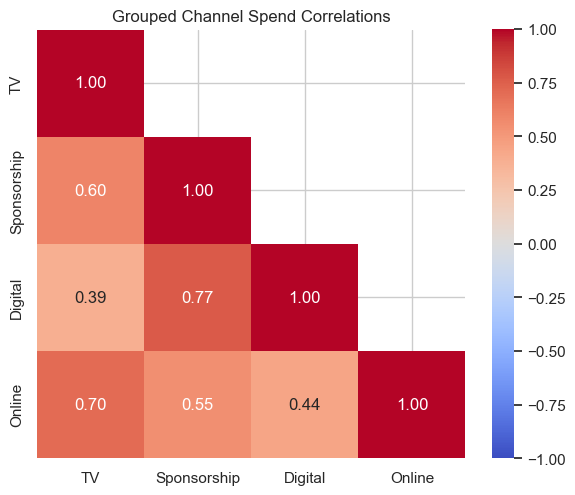


Max absolute off-diagonal correlation: 0.77


In [5]:
# Correlation matrix of grouped channels (should show reduced multicollinearity)
corr = df[config.channel_columns].corr()
fig, ax = plt.subplots(figsize=(6, 5))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    ax=ax,
    square=True,
)
ax.set_title("Grouped Channel Spend Correlations")
plt.tight_layout()
plt.show()
print(
    "\nMax absolute off-diagonal correlation:",
    f"{corr.where(~np.eye(len(corr), dtype=bool)).abs().max().max():.2f}",
)

In [6]:
# Prepare X (features) and y (target)
feature_cols = [
    config.date_column,
    *config.channel_columns,
    *config.control_columns,
]
X = df[feature_cols]
y = df[config.target_column]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X columns: {X.columns.tolist()}")

X shape: (52, 8)
y shape: (52,)
X columns: ['Date', 'TV', 'Sponsorship', 'Digital', 'Online', 'NPS', 'total_Discount', 'sale_days']


---
## Step 3: Initialize Model

In [7]:
mmm = build_model(config)

print(f"Model type: {type(mmm).__name__}")
print(f"Date column: {mmm.date_column}")
print(f"Channel columns: {mmm.channel_columns}")
print(f"Control columns: {mmm.control_columns}")
print(f"Adstock: {mmm.adstock} (l_max={mmm.adstock.l_max})")
print(f"Saturation: {mmm.saturation}")

Model type: MMM
Date column: Date
Channel columns: ['TV', 'Sponsorship', 'Digital', 'Online']
Control columns: ['NPS', 'total_Discount', 'sale_days']
Adstock: GeometricAdstock(prefix='adstock', l_max=4, normalize=True, mode='After', priors={'alpha': Prior("Beta", alpha=1, beta=3, dims="channel")}) (l_max=4)
Saturation: LogisticSaturation(prefix='saturation', priors={'lam': Prior("Gamma", alpha=3, beta=1, dims="channel"), 'beta': Prior("HalfNormal", sigma=2, dims="channel")})


---
## Step 4: Prior Predictive Check

Before fitting, verify that the priors produce plausible total_gmv values.

Sampling: [adstock_alpha, gamma_control, intercept, saturation_beta, saturation_lam, y, y_sigma]


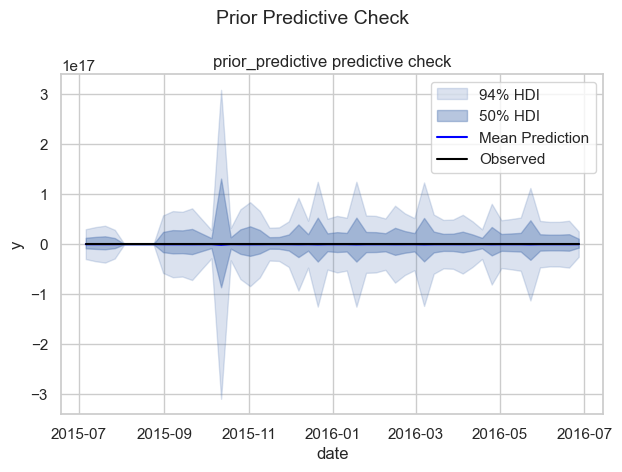

In [8]:
sample_prior_predictive(mmm, X, y, samples=500)

fig = mmm.plot_prior_predictive(original_scale=True)
if hasattr(fig, "suptitle"):
    fig.suptitle("Prior Predictive Check", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Assess prior predictive range
prior_pred = mmm.idata.prior_predictive
print(f"Observed target range: {y.min():.0f} to {y.max():.0f}")
print(f"Observed target mean: {y.mean():.0f}")
print()
print(
    "If prior predictive range is unrealistic, adjust priors in config.get_model_config()"
)

Observed target range: 11712 to 295492714
Observed target mean: 74694222

If prior predictive range is unrealistic, adjust priors in config.get_model_config()


---
## Step 5: Fit Model (MCMC Sampling)

This will take several minutes. Running 4 chains × 1000 draws + 2000 tune,
with target_accept=0.95 and ADVI+adapt_diag initialization for better convergence.

In [10]:
%%time
idata = fit_model(mmm, X, y, config)
print("\nSampling complete.")
print(f"Posterior dims: {dict(idata.posterior.dims)}")

Initializing NUTS using advi+adapt_diag...


Output()

Convergence achieved at 49000
Interrupted at 48,999 [24%]: Average Loss = 1.5364e+16
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 182 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Sampling complete.
Posterior dims: {'chain': 4, 'draw': 1000, 'control': 3, 'channel': 4, 'date': 52}
CPU times: user 24.6 s, sys: 877 ms, total: 25.4 s
Wall time: 3min 28s


---
## Step 6: Convergence Diagnostics

Diagnostic checks:
- R-hat < 1.01 for all parameters
- ESS (bulk) > 400 for all parameters
- Zero divergences

In [11]:
diag = check_convergence(idata)

print(f"PASSED: {diag.passed}")
print(f"R-hat OK: {diag.rhat_ok} (max: {diag.max_rhat:.4f})")
print(f"ESS OK: {diag.ess_ok} (min: {diag.min_ess:.0f})")
print(f"Divergences: {diag.divergences}")
print(f"\nSummary: {diag.summary}")

PASSED: False
R-hat OK: False (max: 4.1400)
ESS OK: False (min: 4)
Divergences: 0

Summary: R-hat too high: 4.1400 (threshold: 1.01); ESS too low: 4 (threshold: 400)


In [12]:
# Trace plots for visual inspection
trace_path = plot_trace(idata)
print(f"Trace plot saved to: {trace_path}")

Trace plot saved to: outputs/plots/diagnostics/trace_2026-02-13.png


In [12]:
# Full parameter summary
summary = az.summary(idata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.037,0.455,-0.581,0.695,0.227,0.110,4.0,16.0,4.10
gamma_control[NPS],0.079,0.180,-0.081,0.386,0.090,0.050,5.0,27.0,2.91
gamma_control[total_Discount],-0.000,0.000,-0.000,0.000,0.000,0.000,5.0,16.0,2.67
gamma_control[sale_days],0.091,0.319,-0.254,0.613,0.159,0.085,4.0,11.0,4.17
adstock_alpha[TV],0.340,0.095,0.177,0.417,0.047,0.027,4.0,14.0,3.97
...,...,...,...,...,...,...,...,...,...
mu[2016-05-30T00:00:00.000000],3.030,4.872,0.174,11.901,2.422,1.405,5.0,13.0,2.51
mu[2016-06-06T00:00:00.000000],3.282,5.625,-0.333,13.454,2.797,1.619,5.0,28.0,2.47
mu[2016-06-13T00:00:00.000000],3.177,5.549,-0.501,13.215,2.760,1.596,5.0,28.0,2.45
mu[2016-06-20T00:00:00.000000],2.951,5.250,-0.662,12.482,2.610,1.508,5.0,28.0,2.44


In [13]:
# Gate: warn if diagnostics fail (soft gate — continue for exploration)
if diag.passed:
    print("Convergence gate PASSED - safe to interpret results.")
else:
    print(f"WARNING: {diag.summary}")
    print("Results below should be interpreted with caution.")

Results below should be interpreted with caution.


---
## Step 7: Posterior Predictive Check

Verify the fitted model can reproduce the observed data.

Sampling: [y]


Output()

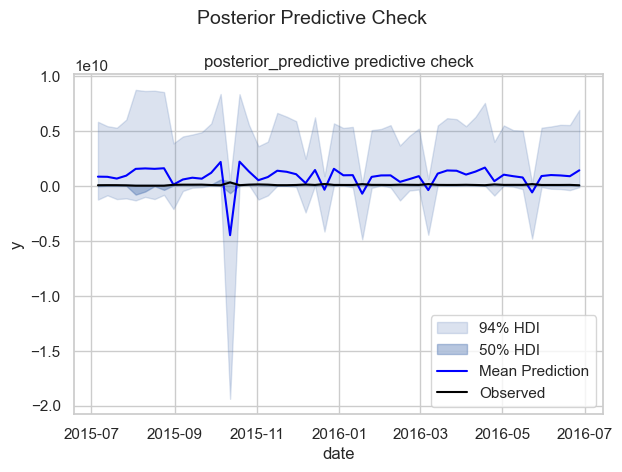

In [14]:
sample_posterior_predictive(mmm, X)

fig = mmm.plot_posterior_predictive(original_scale=True)
if hasattr(fig, "suptitle"):
    fig.suptitle("Posterior Predictive Check", fontsize=14)
plt.tight_layout()
plt.show()

---
## Step 8: Channel Decomposition & Contributions

In [15]:
# Channel contributions plot
contrib_path = plot_channel_contributions(mmm)
print(f"Channel contributions plot saved to: {contrib_path}")

Channel contributions plot saved to: outputs/plots/contributions/channel_contributions_2026-02-13.png


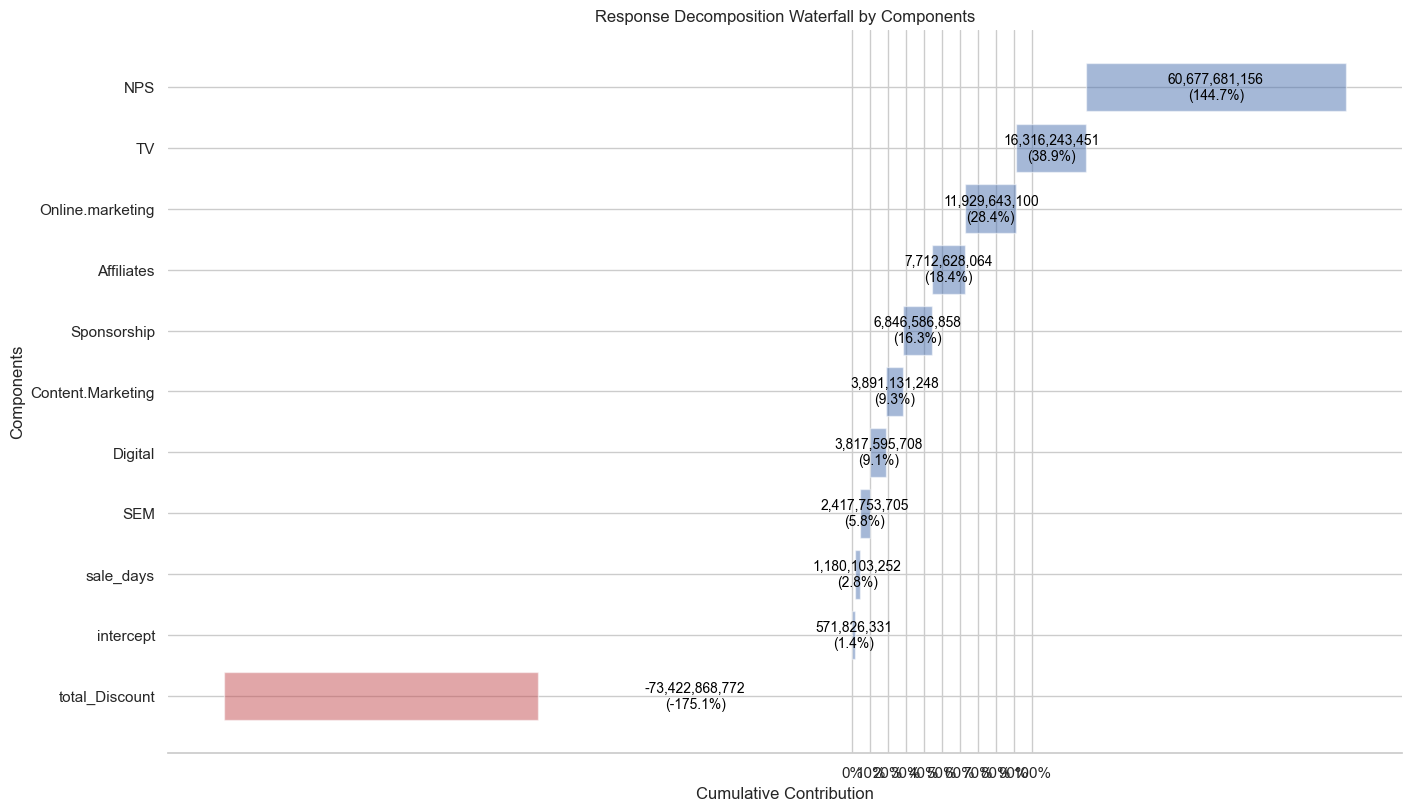

In [16]:
# Waterfall decomposition
fig = mmm.plot_waterfall_components_decomposition(original_scale=True, figsize=(14, 8))
plt.show()

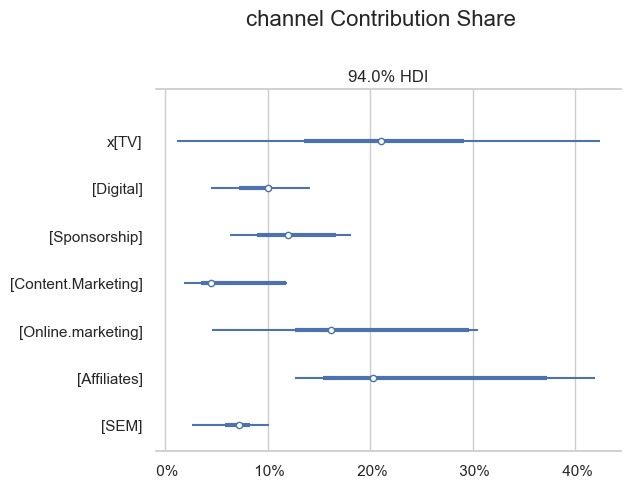

In [17]:
# Channel contribution share with HDI (credible intervals)
fig = mmm.plot_channel_contribution_share_hdi(hdi_prob=0.94)
plt.show()

In [ ]:
# Grouped contribution breakdown over time (4 channel groups)
fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups={
        "Baseline": ["intercept"],
        "Offline": ["TV", "Sponsorship"],
        "Online": ["Digital", "Online"],
        "Controls": ["NPS", "total_Discount", "sale_days"],
    },
    original_scale=True,
    figsize=(14, 6),
)
plt.show()

### Adstock & Saturation Curves

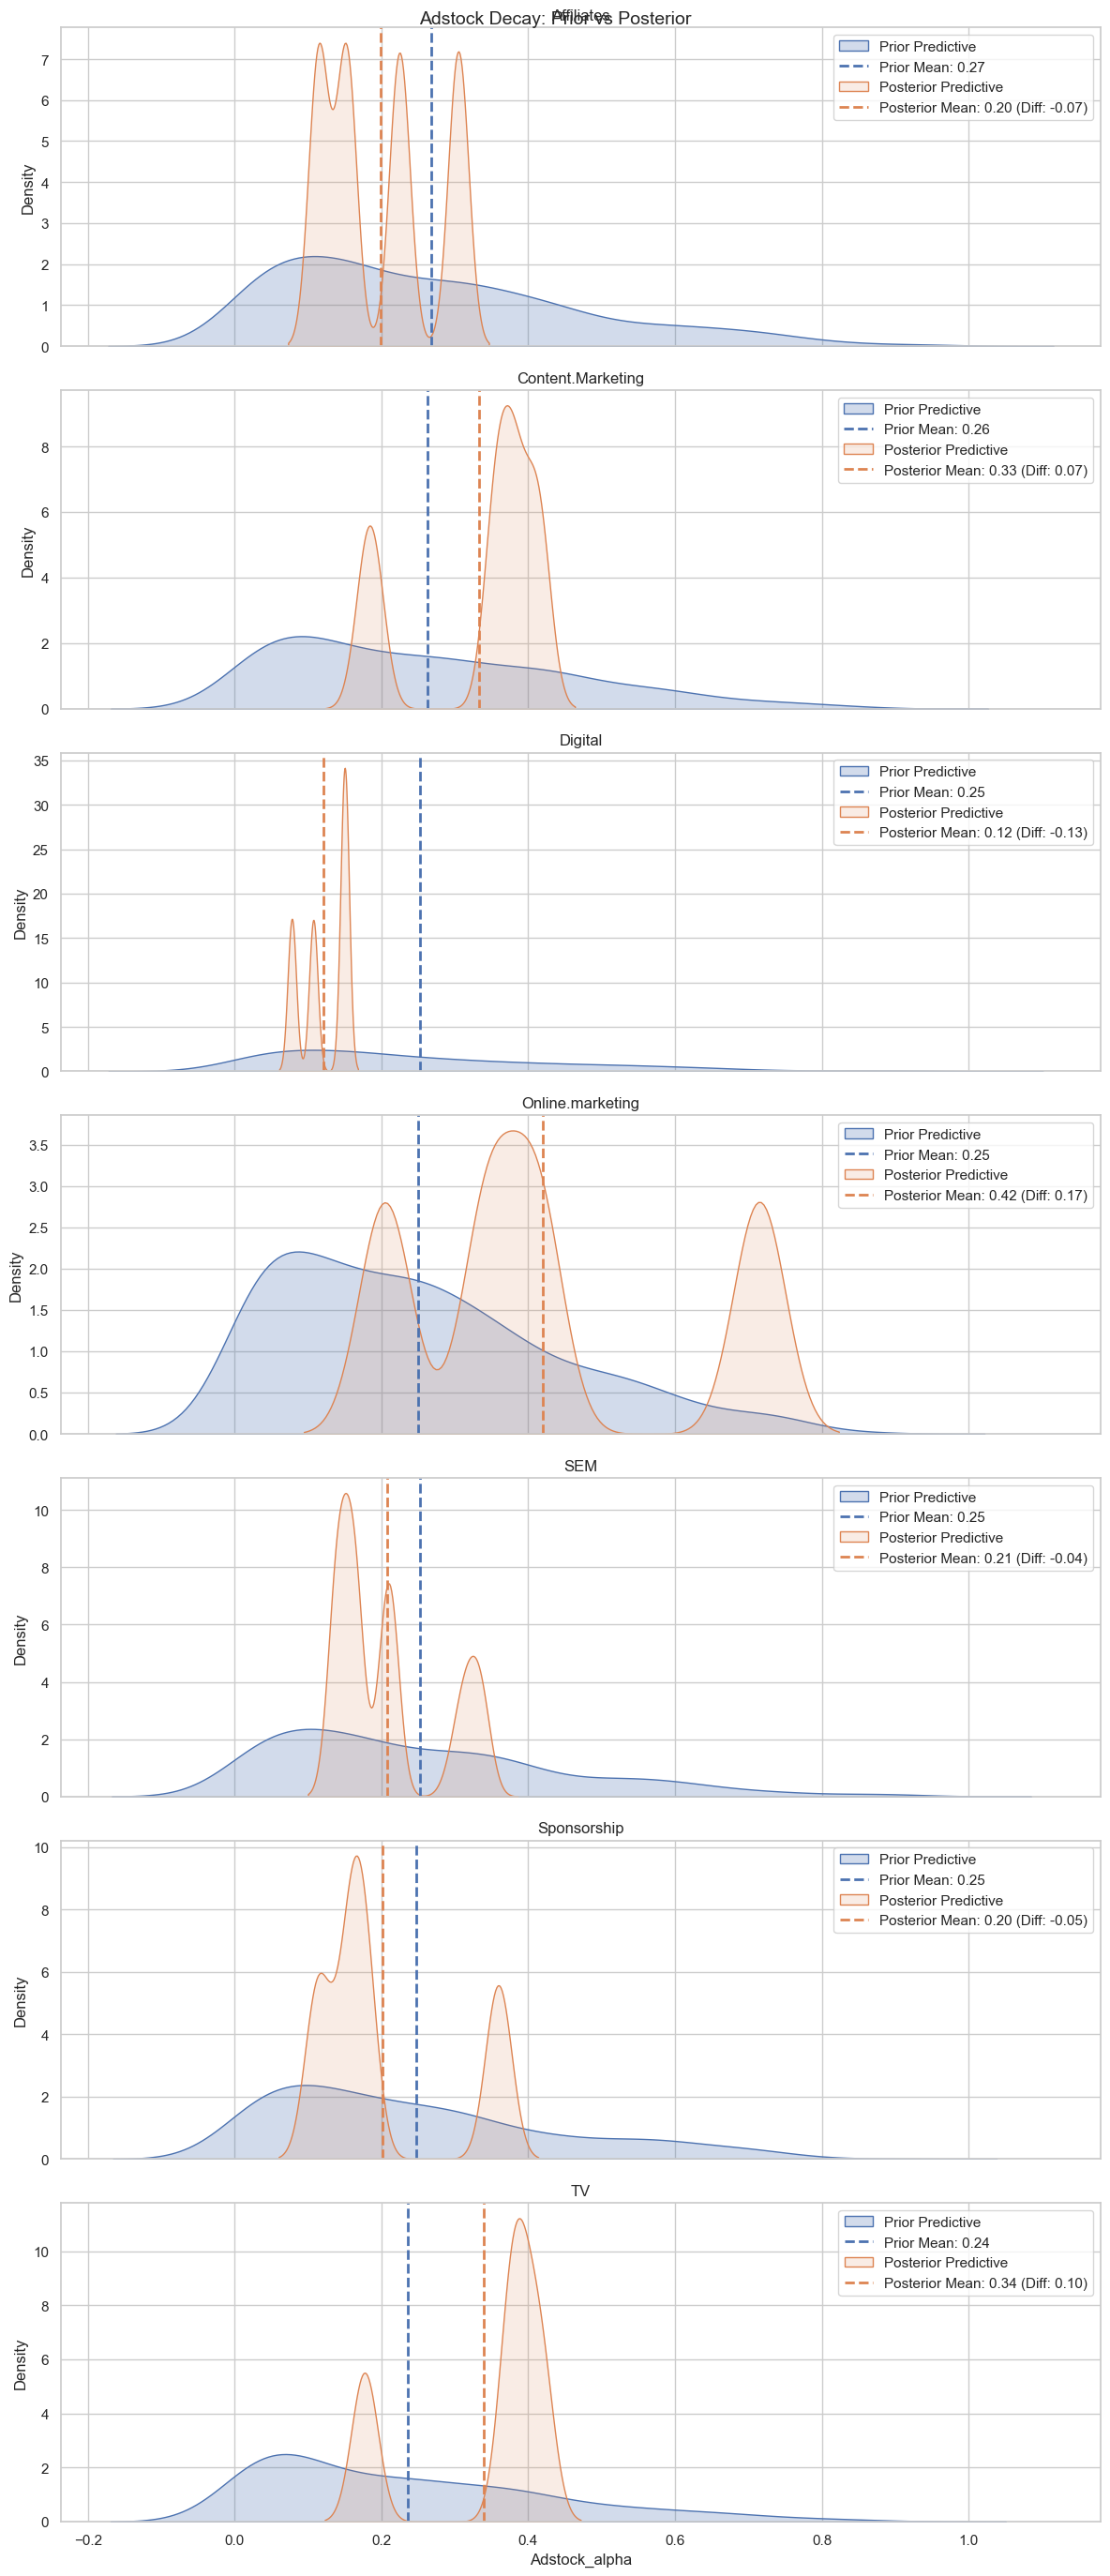

In [19]:
# Prior vs posterior for adstock decay
fig = mmm.plot_prior_vs_posterior("adstock_alpha", alphabetical_sort=True)
plt.suptitle("Adstock Decay: Prior vs Posterior", fontsize=14)
plt.tight_layout()
plt.show()

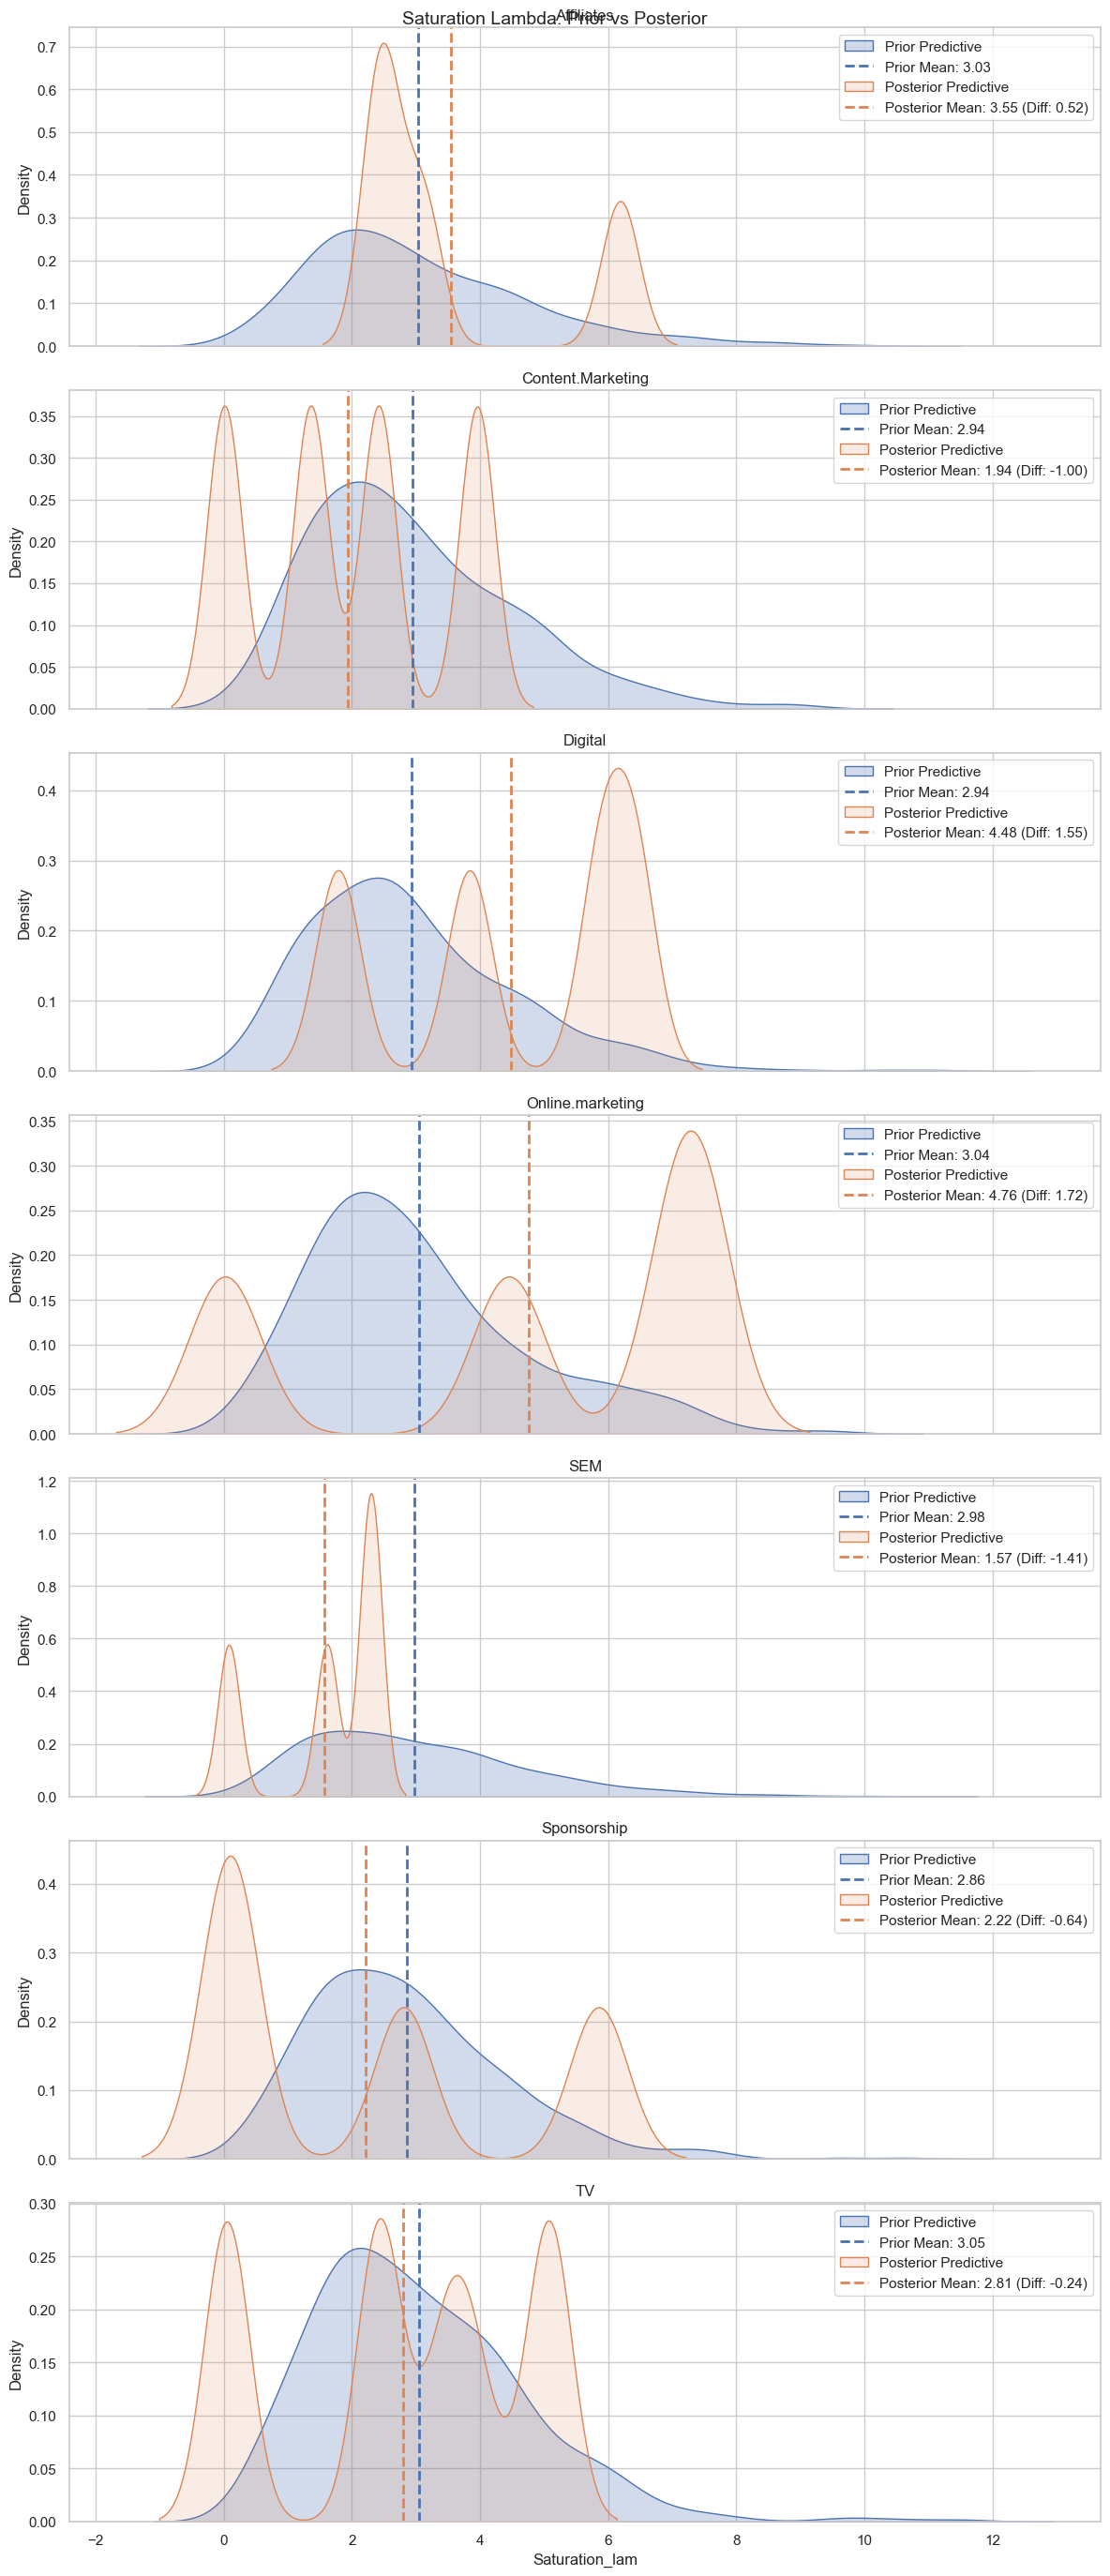

In [20]:
# Prior vs posterior for saturation parameters
fig = mmm.plot_prior_vs_posterior("saturation_lam", alphabetical_sort=True)
plt.suptitle("Saturation Lambda: Prior vs Posterior", fontsize=14)
plt.tight_layout()
plt.show()

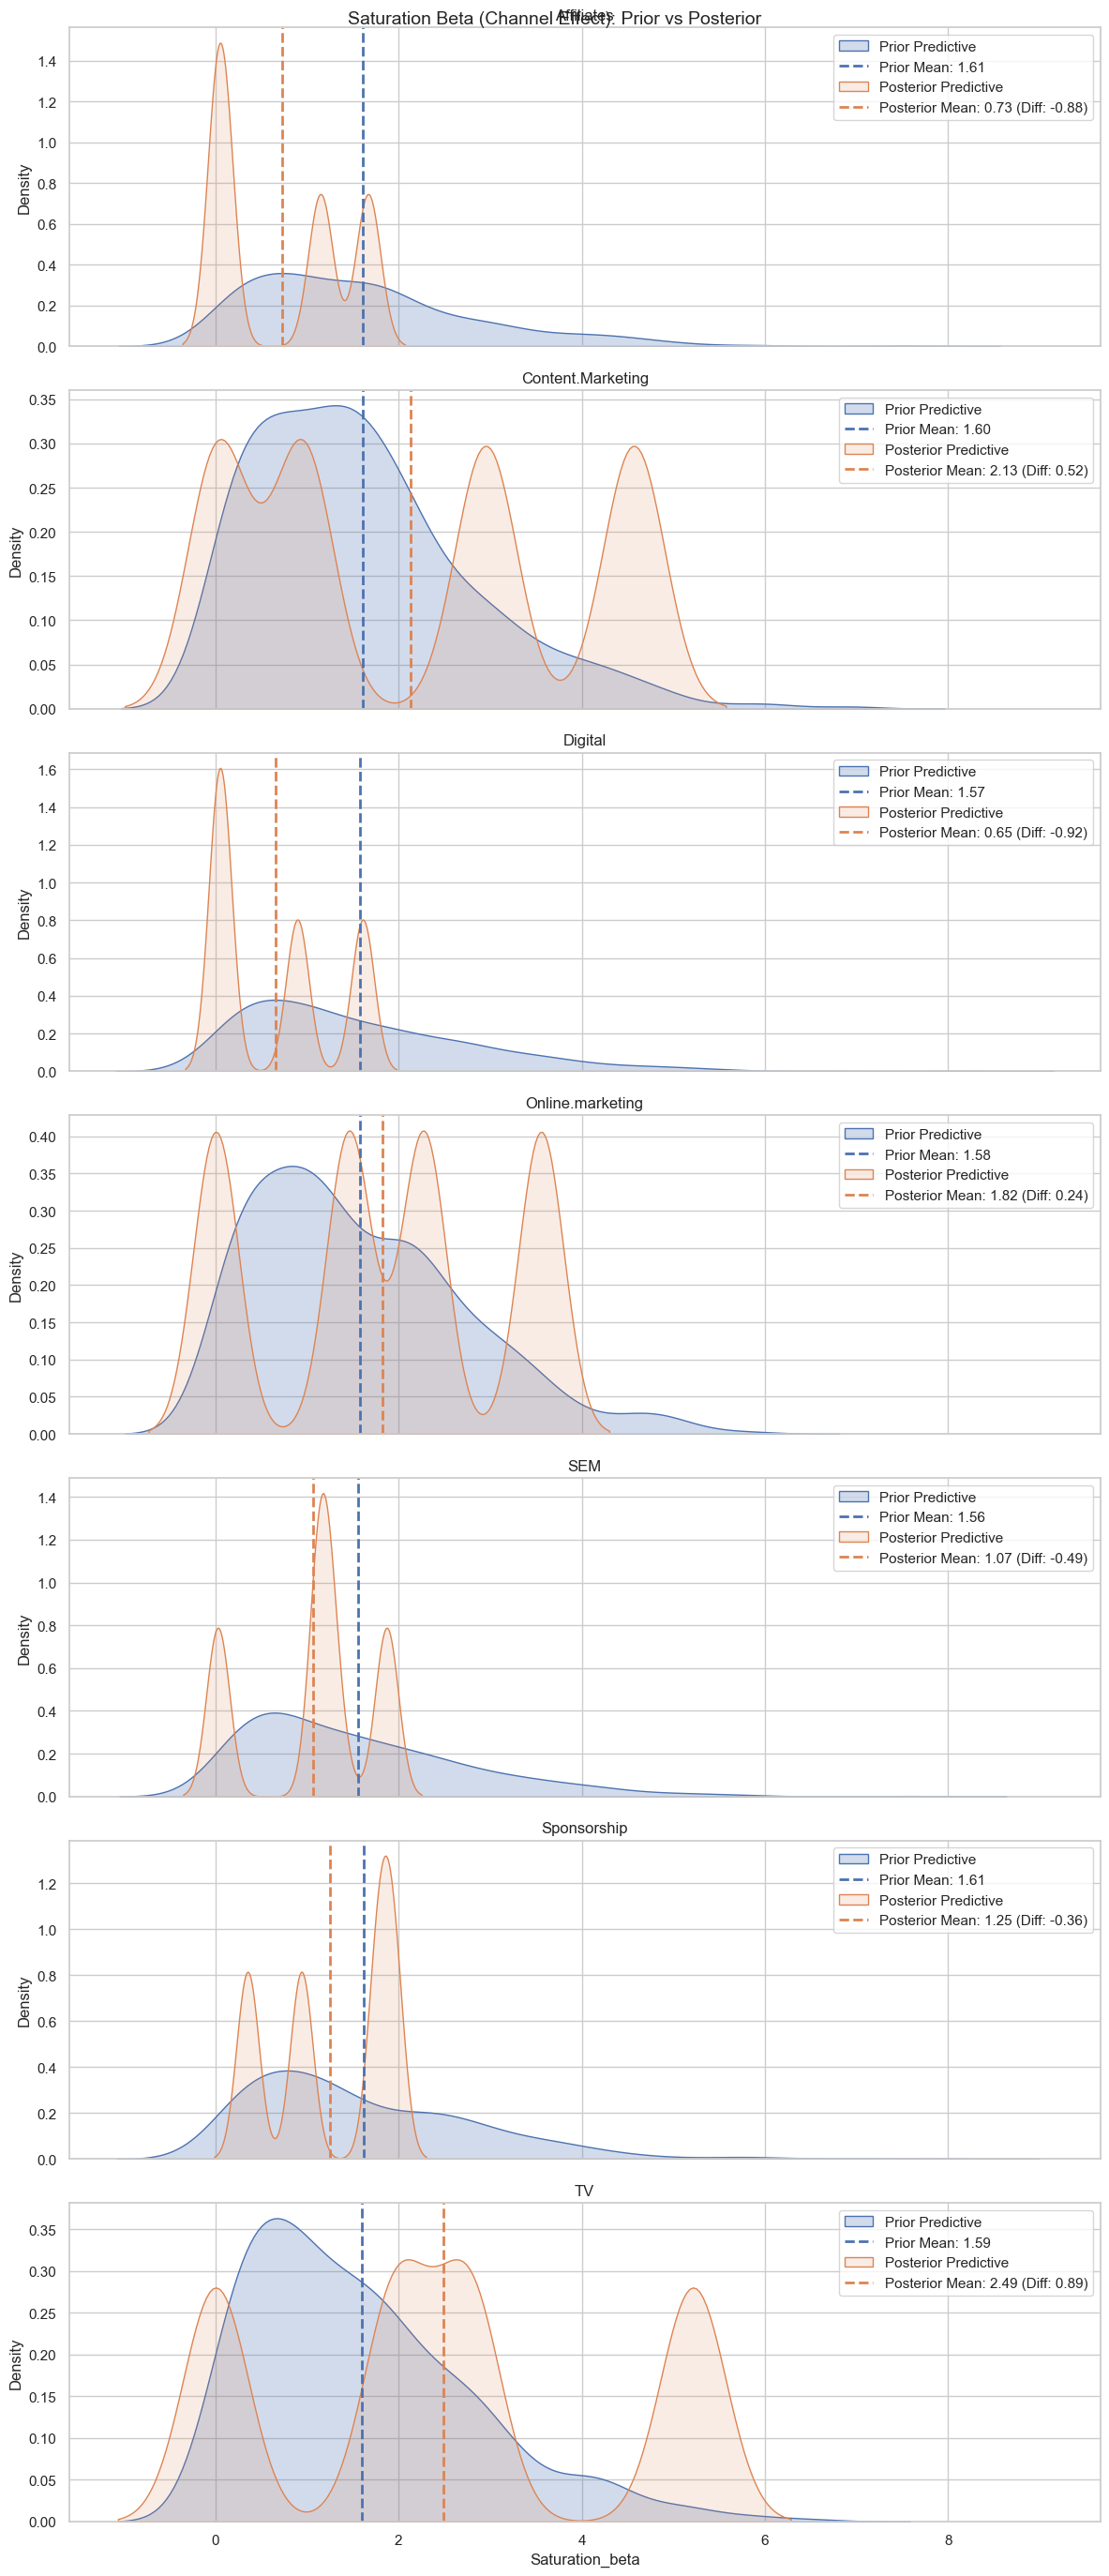

In [21]:
fig = mmm.plot_prior_vs_posterior("saturation_beta", alphabetical_sort=True)
plt.suptitle("Saturation Beta (Channel Effect): Prior vs Posterior", fontsize=14)
plt.tight_layout()
plt.show()

### Mean Contributions

In [22]:
# Compute mean contributions over time
contributions = mmm.compute_mean_contributions_over_time(original_scale=True)
print("Mean contributions over time:")
contributions

Mean contributions over time:


,TV,Digital,Sponsorship,Content.Marketing,Online.marketing,Affiliates,SEM,NPS,total_Discount,sale_days,intercept
date,,,,,,,,,,,
2015-07-06,1.600885e+07,9.090624e+07,4.401113e+07,0.000000e+00,3.341574e+07,2.433222e+07,2.978117e+07,1.282419e+09,-7.275110e+08,0.000000e+00,1.099666e+07
2015-07-13,2.231610e+07,1.018410e+08,4.978720e+07,0.000000e+00,4.559440e+07,2.769035e+07,3.499419e+07,1.282419e+09,-8.306321e+08,5.364106e+07,1.099666e+07
2015-07-20,2.480693e+07,1.033993e+08,5.060416e+07,0.000000e+00,5.009791e+07,2.817617e+07,3.593966e+07,1.282419e+09,-8.979104e+08,0.000000e+00,1.099666e+07
2015-07-27,2.579227e+07,1.036308e+08,5.072665e+07,0.000000e+00,5.178643e+07,2.825002e+07,3.611690e+07,1.282419e+09,-6.991223e+08,0.000000e+00,1.099666e+07
2015-08-03,1.018896e+07,5.675841e+07,1.227655e+07,0.000000e+00,2.150908e+07,7.950241e+06,1.845298e+07,1.409252e+09,-5.779766e+05,0.000000e+00,1.099666e+07
2015-08-10,4.029527e+06,4.881157e+07,7.006697e+06,0.000000e+00,1.013535e+07,5.062575e+06,1.528377e+07,1.409252e+09,-3.739879e+05,5.364106e+07,1.099666e+07
2015-08-17,1.595381e+06,4.760592e+07,6.261389e+06,0.000000e+00,5.881400e+06,4.642350e+06,1.470695e+07,1.409252e+09,-4.224333e+05,2.682053e+07,1.099666e+07
2015-08-24,6.322744e+05,4.742493e+07,6.150207e+06,0.000000e+00,4.280386e+06,4.578436e+06,1.459894e+07,1.409252e+09,-9.174052e+05,8.046159e+07,1.099666e+07
2015-08-31,2.410935e+05,4.739776e+07,6.132593e+06,0.000000e+00,3.657439e+06,4.568050e+06,1.457786e+07,1.409252e+09,-1.401006e+09,0.000000e+00,1.099666e+07


---
## Save Model

In [23]:
from datetime import datetime

date_str = datetime.now().strftime("%Y-%m-%d")
model_path = OUTPUTS_DIR / "models" / f"mmm_fit_{date_str}_v1.nc"
model_path.parent.mkdir(parents=True, exist_ok=True)
mmm.save(str(model_path))
print(f"Model saved to: {model_path}")

Model saved to: outputs/models/mmm_fit_2026-02-13_v1.nc


---
## Summary

### Results
- Model fitted with 4 chains × 1000 draws + 2000 tune on ~52 weekly observations
- **4 grouped channels** (TV, Sponsorship, Digital, Online) — reduced from 7 raw channels
- ADVI+adapt_diag initialization for better MCMC starting points
- Convergence diagnostics: check results above
- Channel contributions decomposed with uncertainty (HDI)
- Adstock and saturation parameters estimated per channel group

### Channel Grouping
- **TV**: TV (independent, max r=0.74 with other channels)
- **Sponsorship**: Sponsorship (largest channel at 46.6% spend)
- **Digital**: Digital + SEM + Content.Marketing (r > 0.91 between all pairs)
- **Online**: Online.marketing + Affiliates (r = 0.99)

### Data Pipeline
- Weekly GMV aggregated from ~1.6M daily transactions (firstfile.csv)
- Monthly media spend pro-rata distributed across weeks (MediaInvestment.csv)
- Monthly NPS scores forward-filled to weeks (MonthlyNPSscore.csv)
- Sale event days counted per week (SpecialSale.csv)

### Key Caveats
- Media spend is only available monthly — weekly values are uniformly distributed
- Channel groups combine spend; individual sub-channel effects cannot be separated

### Next Steps
- Notebook 03: Budget optimization using the fitted model
- Sensitivity analysis on priors